<a href="https://colab.research.google.com/github/Hope112/hello-world/blob/master/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df=pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx')


In [4]:
#rename columns
column_names = {'X1':'Relative_Compactness', 'X2': 'Surface_Area', 
                'X3':  'Wall_Area', 'X4': 'Roof_Area', 'X5': 'Overall_Height',
                'X6': 'Orientation', 'X7': 'Glazing_Area', 
                'X8': 'Glazing_Area_Distribution', 
                'Y1': 'Heating_Load', 'Y2': 'Cooling_Load'}

In [5]:
df = df.rename(columns=column_names)
df

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


In [6]:
#select a sample of the dataset
simple_linear_reg_df = df[['Relative_Compactness', 'Cooling_Load']].sample(15, random_state=2)
simple_linear_reg_df

,Relative_Compactness,Cooling_Load
158,0.82,25.35
251,0.86,31.28
631,0.90,33.31
757,0.66,17.79
689,0.79,47.59
573,0.62,17.21
553,0.74,17.25
728,0.86,29.69
183,0.66,13.83
515,0.69,14.60


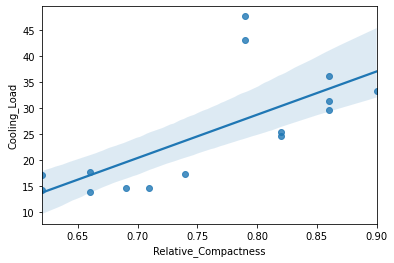

In [7]:
#regression plot
sns.regplot(x="Relative_Compactness", y="Cooling_Load", data=simple_linear_reg_df)


In [9]:
#Firstly, we normalise our dataset to a common scale using the min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalised_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
features_df = normalised_df.drop(columns=['Heating_Load', 'Cooling_Load'])
heating_target = normalised_df['Heating_Load']


In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features_df, heating_target, test_size=0.3, random_state=1)


In [11]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
#fit the model to the training dataset
linear_model.fit(x_train, y_train)
#obtain predictions
predicted_values = linear_model.predict(x_test)

In [12]:
#MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predicted_values)
round(mae, 3) 	#prints 0.063

0.063

In [13]:
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, predicted_values)
round(r2_score, 3)	#prints 0.893

0.893

In [14]:
import numpy as np
rss = np.sum(np.square(y_test - predicted_values))
round(rss, 3)	    #prints 1.823

1.823

In [15]:
from sklearn.metrics import  mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, predicted_values))
round(rmse, 3) 	#prints 0.089

0.089

In [16]:
#lasso regression
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [17]:
#ridge regression
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.5)
ridge_reg.fit(x_train, y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [18]:
#comparing the effects of regularisation
def get_weights_df(model, feat, col_name):
  #this function returns the weight of every feature
  weights = pd.Series(model.coef_, feat.columns).sort_values()
  weights_df = pd.DataFrame(weights).reset_index()
  weights_df.columns = ['Features', col_name]
  weights_df[col_name].round(3)
  return weights_df


In [19]:
linear_model_weights = get_weights_df(linear_model, x_train, 'Linear_Model_Weight')
ridge_weights_df = get_weights_df(ridge_reg, x_train, 'Ridge_Weight')
lasso_weights_df = get_weights_df(lasso_reg, x_train, 'Lasso_weight')

final_weights = pd.merge(linear_model_weights, ridge_weights_df, on='Features')
final_weights = pd.merge(final_weights, lasso_weights_df, on='Features')
final_weights

,Features,Linear_Model_Weight,Ridge_Weight,Lasso_weight
0,Surface_Area,-6.387091e+12,-0.062275,0.000000
1,Relative_Compactness,-6.064125e-01,-0.283471,-0.027719
2,Orientation,-2.822876e-03,0.003369,0.000000
3,Glazing_Area_Distribution,1.913548e-02,0.029088,0.021431
4,Glazing_Area,2.295933e-01,0.212449,0.206132
5,Overall_Height,3.852539e-01,0.442467,0.463482
6,Wall_Area,3.725803e+12,0.103061,0.200087
7,Roof_Area,4.790318e+12,-0.163192,-0.000000
